In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from collections import deque
import numpy as np
import random
import time
import joblib


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [3]:
dataset = read_csv('final_data.csv', header=0, index_col=0)
dataset[8320:].to_csv("data_test.csv")
data_train=dataset[:8320]
values = data_train.values
values = data_train.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 3, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14]], axis=1, inplace=True)

In [4]:
# split into train and test sets
values = reframed.values
n_train = 288 * 26
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(7488, 1, 12) (7488,) (829, 1, 12) (829,)


Epoch 1/50
125/125 - 11s - loss: 0.3353 - val_loss: 0.0629 - 11s/epoch - 87ms/step
Epoch 2/50
125/125 - 1s - loss: 0.0586 - val_loss: 0.0154 - 1s/epoch - 9ms/step
Epoch 3/50
125/125 - 1s - loss: 0.0177 - val_loss: 0.0095 - 954ms/epoch - 8ms/step
Epoch 4/50
125/125 - 1s - loss: 0.0113 - val_loss: 0.0075 - 826ms/epoch - 7ms/step
Epoch 5/50
125/125 - 1s - loss: 0.0091 - val_loss: 0.0066 - 827ms/epoch - 7ms/step
Epoch 6/50
125/125 - 1s - loss: 0.0082 - val_loss: 0.0054 - 809ms/epoch - 6ms/step
Epoch 7/50
125/125 - 1s - loss: 0.0074 - val_loss: 0.0048 - 886ms/epoch - 7ms/step
Epoch 8/50
125/125 - 1s - loss: 0.0070 - val_loss: 0.0054 - 869ms/epoch - 7ms/step
Epoch 9/50
125/125 - 1s - loss: 0.0069 - val_loss: 0.0041 - 825ms/epoch - 7ms/step
Epoch 10/50
125/125 - 1s - loss: 0.0066 - val_loss: 0.0037 - 875ms/epoch - 7ms/step
Epoch 11/50
125/125 - 1s - loss: 0.0054 - val_loss: 0.0037 - 888ms/epoch - 7ms/step
Epoch 12/50
125/125 - 1s - loss: 0.0054 - val_loss: 0.0037 - 904ms/epoch - 7ms/step
Epoc

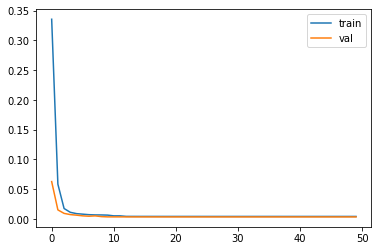

In [5]:
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

# fit network
model.compile(optimizer = 'adam', loss = 'mae')

history = model.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(val_X, val_y),verbose=2,shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [6]:
joblib.dump(scaler, 'std_scaler.bin', compress=True)
model.save('train.h5')

In [8]:
#test model
sc=joblib.load('std_scaler.bin')
new_model = load_model('train.h5')
test_dt = read_csv('data_test.csv', header=0, index_col=0)
total=[]
for i in range(10):
    collect_data=test_dt.values[i]
    print('colect data :',collect_data)
    collect_data=np.array(collect_data).reshape(1,4)
    collect_data = collect_data.astype('float32')
    collect_data = sc.transform(collect_data)
    total.append(collect_data)
    if len(total)>=3:
        if len(total)>3:
            total.pop(0)
        x_pred=np.concatenate([total[0][0],total[1][0],total[2][0]])
        x_pred=x_pred.reshape(1,1,12)
        y_h=new_model.predict(x_pred)
        print('predict : ',1 if y_h[0][0]>0.5 else 0)
        
    time.sleep(5)
    

colect data : [55.17 83.94 17.29  0.  ]


C:\Users\PC\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
